In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append("../")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.run_scripts.read_config import read_config
from neuralbridge.stochastic_processes.examples import SDEFactory
from neuralbridge.models import neurb, pCN, score
from neuralbridge.utils.plotting import plot_sample_path, plot_mcmc_sample_path
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.utils.t_grid import TimeGrid
from neuralbridge.utils.sample_path import SamplePath

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


### Conditioning on normal events

#### Neural bridge

In [20]:
config = read_config("../configs/cell_normal.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

tGrid = TimeGrid(config.sde.T, config.sde.dt, config.sde.t_scheme)
W = WienerProcess(config.sde.W_dim)

X_unc, _ = SDEFactory(config).get_sde()
neural_bridge_model = neurb.NeuralBridge(config)
_ = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_neu = neural_bridge_model.build_neural_bridge()

X_neu_solver = Euler(X_neu, W, tGrid)
X_neu_path = X_neu_solver.solve(
    x0=u, 
    enforced_endpoint=v, 
    batch_size=30,
    training=False
)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/cell_normal_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


{'sde': {'name': 'cell', 'X_dim': 2, 'W_dim': 2, 'T': 4.0, 'dt': 0.01, 't_scheme': 'linear', 'params_X_unc': {'alpha': 0.0625, 'sigma': 0.1}, 'params_X_aux': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [0.1, -0.1], 'v': [2.0, -0.1], 'eps': 1e-10}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 2, 'hidden_dims': [32, 32, 32, 32], 'activation': 'tanh', 'normalization_type': None, 'dropout_rate': 0.0}, 'training': {'save_name': 'cell_normal_tanh_linear_None_norm_0.0_dropout_adam_opt', 'learning_rate': 0.0005, 'batch_size': 20, 'n_iters_per_epoch': 500, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps_ratio': 0.1, 'clip_norm': 1.0}, 'mcmc': {'eta': 0.98, 'n_chains': 1, 'n_iters': 10000, 'n_burn_in': 4000}}


#### Score matching

In [21]:
config = read_config("../configs/cell_normal_score.yaml")
print(config)

score_model = score.ScoreMatchingReversedBridge(config)
_ = score_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/score/")
Y_score = score_model.build_reversed_bridge()

Y_score_solver = Euler(Y_score, W, tGrid)
Y_score_path = Y_score_solver.solve(
    x0=v,
    enforced_endpoint=u,
    batch_size=30,
    training=False
)
X_score_path = SamplePath(
    xs=Y_score_path.xs[:, ::-1, :],
    ts=Y_score_path.ts
)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/score/cell_normal_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


{'sde': {'name': 'cell', 'X_dim': 2, 'W_dim': 2, 'T': 4.0, 'dt': 0.01, 't_scheme': 'linear', 'params_X_unc': {'alpha': 0.0625, 'sigma': 0.1}, 'params_X_aux': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [0.1, -0.1], 'v': [2.0, -0.1]}, 'network': {'mlp_type': 'mlp', 'out_dim': 2, 'hidden_dims': [32, 32, 32, 32], 't_emb_dim': 32, 't_emb_max_period': 100.0, 't_emb_scaling': 100.0, 'activation': 'tanh', 'normalization_type': None, 'dropout_rate': 0.0}, 'training': {'save_name': 'cell_normal_tanh_linear_None_norm_0.0_dropout_adam_opt', 'learning_rate': 0.0005, 'batch_size': 32, 'n_iters_per_epoch': 1000, 'n_epochs': 20, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps_ratio': 0.1, 'clip_norm': 1.0}}


#### Adjoint forward

In [22]:
config = read_config("../configs/cell_normal_adjoint.yaml")
print(config)

from flax.training import checkpoints
from legacies.adjoint_forward.models.score_mlp import ScoreMLP
from legacies.adjoint_forward.sdes import sde_cell_model, sde_utils
from legacies.adjoint_forward.training import train_utils
network = ScoreMLP(**config.network)
ckpt = checkpoints.restore_checkpoint(
    ckpt_dir=os.path.abspath("../assets/ckpts/adjoint/cell_model_normal_0.1sigma"),
    target=None,
    step=0,
    prefix="checkpoint_"
)
params = ckpt["params"]
batch_stats = ckpt["batch_stats"]
trained_score = train_utils.trained_score(network, params, batch_stats)

cell_sde = sde_cell_model.cell_model(
    T=config.sde.T, 
    N=int(config.sde.T / config.sde.dt), 
    alpha=config.sde.alpha, 
    sigma=config.sde.sigma
)
n_samples = 30
rng_keys = jax.random.split(jax.random.PRNGKey(42), n_samples)
xs_star = jax.vmap(
    sde_utils.conditioned,
    in_axes=(0, None, None, None)
)(rng_keys, u, cell_sde, trained_score)
ts = jnp.arange(0, config.sde.T, config.sde.dt)
X_adjoint_path = SamplePath(
    xs=xs_star,
    ts=ts
)

{'sde': {'T': 4.0, 'dt': 0.01, 'N': 400, 'alpha': 0.0625, 'sigma': 0.1, 'u': [0.1, -0.1], 'v': [2.0, -0.1]}, 'network': {'output_dim': 2, 'time_embedding_dim': 32, 'init_embedding_dim': 16, 'activation': 'leaky_relu', 'encoder_layer_dims': [16], 'decoder_layer_dims': [128, 128]}, 'training': {'v': None, 'batch_size': 100, 'epochs_per_load': 1, 'lr': 0.01, 'num_reloads': 100, 'load_size': 100000}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


#### Pre-conditioned Crank-Nicolson

In [23]:
config = read_config("../configs/cell_normal.yaml")

pcn_model = pCN.PreconditionedCrankNicolson(
    X=neural_bridge_model.X_gui,
    config=config
)
pcn_logs, _ = pcn_model.run(log_every=200)

Running pCN with log every 200: 100%|██████████| 10000/10000 [00:05<00:00, 1873.41it/s]
INFO:root:Batch average acceptance rate: 22.69%


In [24]:
X_pcn_path = SamplePath(
    xs = jnp.concatenate([pcn_logs[i].path.xs for i in range(len(pcn_logs))]),
    ts = pcn_logs[0].path.ts
)

#### Brutal force sampling to obtain the "ground truth"

In [26]:
X_unc_solver = Euler(X_unc, W, tGrid)
X_unc_path = X_unc_solver.solve(
    x0=u, 
    batch_size=100_000)
# Create masks for each component's end point conditions
x1_mask = (X_unc_path.xs[:, -1, 0] >= v[0] - 1e-2) & (X_unc_path.xs[:, -1, 0] <= v[0] + 1e-2)
x2_mask = (X_unc_path.xs[:, -1, 1] >= v[1] - 1e-2) & (X_unc_path.xs[:, -1, 1] <= v[1] + 1e-2)
final_mask = x1_mask & x2_mask
X_cond_path = X_unc_path[final_mask]
print(f"Found {X_cond_path.n_samples} samples that satisfy the endpoint conditions out of {X_unc_path.n_samples} samples")

Found 151 samples that satisfy the endpoint conditions out of 100000 samples


In [27]:
def make_subplot(ax, X_path, title):
    plot_sample_path(
        X_cond_path[:30], 
        ax=ax,
        colors=["grey", "grey"],
        line_plot_kwargs={
            "alpha": 0.5, 
            "linewidth": 2.0, 
            "zorder": 1
        }
    )
    plot_sample_path(
        X_path[:30], 
        ax=ax,
        labels=["$X_{t,1}$", "$X_{t,2}$"],
        line_plot_kwargs={
            "alpha": 0.5, 
            "linewidth": 2.0, 
            "zorder": 2
        }
    )
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.scatter([0.0, 0.0], u, c="cyan", s=50, marker="o", edgecolor="black", linewidth=1.0, label=r"$x_0$", zorder=3)
    ax.scatter([4.0, 4.0], v, c="yellow", s=50, marker="o", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
    ax.legend(fontsize=14, loc="upper left")
    ax.set_title(title, fontsize=18)

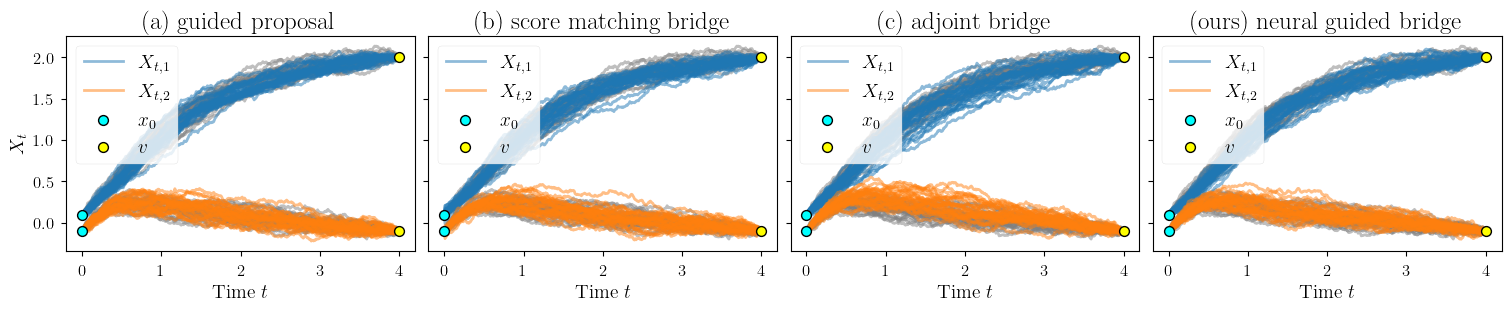

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), layout="constrained", sharex=True, sharey=True)
make_subplot(axes[0], X_pcn_path, "(a) guided proposal")
make_subplot(axes[1], X_score_path, "(b) score matching bridge")
make_subplot(axes[2], X_adjoint_path, "(c) adjoint bridge")
make_subplot(axes[3], X_neu_path, "(ours) neural guided bridge")

axes[0].set_ylabel(r"$X_t$", fontsize=14)
axes[0].set_xlabel(r"Time $t$", fontsize=14)
axes[1].set_xlabel(r"Time $t$", fontsize=14)
axes[2].set_xlabel(r"Time $t$", fontsize=14)
axes[3].set_xlabel(r"Time $t$", fontsize=14)

fig.savefig("../assets/figures/cell_model/normal_events_results.pdf", dpi=300, bbox_inches="tight")

### Conditioning on rare events

#### Neural bridge

In [43]:
config = read_config("../configs/cell_rare.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

tGrid = TimeGrid(config.sde.T, config.sde.dt, config.sde.t_scheme)
W = WienerProcess(config.sde.W_dim)

X_unc, _ = SDEFactory(config).get_sde()
neural_bridge_model = neurb.NeuralBridge(config)
_ = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_neu = neural_bridge_model.build_neural_bridge()

X_neu_solver = Euler(X_neu, W, tGrid)
X_neu_path = X_neu_solver.solve(
    x0=u, 
    enforced_endpoint=v, 
    batch_size=30,
    training=False
)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/cell_rare_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


{'sde': {'name': 'cell', 'X_dim': 2, 'W_dim': 2, 'T': 4.0, 'dt': 0.01, 't_scheme': 'linear', 'params_X_unc': {'alpha': 0.0625, 'sigma': 0.1}, 'params_X_aux': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [0.1, -0.1], 'v': [1.0, -0.1], 'eps': 1e-10}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 2, 'hidden_dims': [32, 32, 32, 32], 'activation': 'tanh', 'normalization_type': None, 'dropout_rate': 0.0}, 'training': {'save_name': 'cell_rare_tanh_linear_None_norm_0.0_dropout_adam_opt', 'learning_rate': 0.001, 'batch_size': 20, 'n_iters_per_epoch': 500, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps_ratio': 0.1, 'clip_norm': 1.0}, 'mcmc': {'eta': 0.99, 'n_chains': 1, 'n_iters': 10000, 'n_burn_in': 4000}}


#### Score matching

In [44]:
config = read_config("../configs/cell_rare_score.yaml")
print(config)

score_model = score.ScoreMatchingReversedBridge(config)
_ = score_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/score/")
Y_score = score_model.build_reversed_bridge()

Y_score_solver = Euler(Y_score, W, tGrid)
Y_score_path = Y_score_solver.solve(
    x0=v,
    enforced_endpoint=None,
    batch_size=30,
    training=False
)
X_score_path = SamplePath(
    xs=Y_score_path.xs[:, ::-1, :],
    ts=Y_score_path.ts
)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/score/cell_normal_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


{'sde': {'name': 'cell', 'X_dim': 2, 'W_dim': 2, 'T': 4.0, 'dt': 0.01, 't_scheme': 'linear', 'params_X_unc': {'alpha': 0.0625, 'sigma': 0.1}, 'params_X_aux': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [0.1, -0.1], 'v': [1.0, -0.1]}, 'network': {'mlp_type': 'mlp', 'out_dim': 2, 'hidden_dims': [32, 32, 32, 32], 't_emb_dim': 32, 't_emb_max_period': 100.0, 't_emb_scaling': 100.0, 'activation': 'tanh', 'normalization_type': None, 'dropout_rate': 0.0}, 'training': {'save_name': 'cell_normal_tanh_linear_None_norm_0.0_dropout_adam_opt', 'learning_rate': 0.0005, 'batch_size': 32, 'n_iters_per_epoch': 1000, 'n_epochs': 20, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps_ratio': 0.1, 'clip_norm': 1.0}}


#### Adjoint forward

In [45]:
config = read_config("../configs/cell_rare_adjoint.yaml")
print(config)

network = ScoreMLP(**config.network)
ckpt = checkpoints.restore_checkpoint(
    ckpt_dir=os.path.abspath("../assets/ckpts/adjoint/cell_model_rare_0.1sigma"),
    target=None,
    step=0,
    prefix="checkpoint_"
)
params = ckpt["params"]
batch_stats = ckpt["batch_stats"]
trained_score = train_utils.trained_score(network, params, batch_stats)

cell_sde = sde_cell_model.cell_model(
    T=config.sde.T, 
    N=int(config.sde.T / config.sde.dt), 
    alpha=config.sde.alpha, 
    sigma=config.sde.sigma
)
n_samples = 30
rng_keys = jax.random.split(jax.random.PRNGKey(42), n_samples)
xs_star = jax.vmap(
    sde_utils.conditioned,
    in_axes=(0, None, None, None)
)(rng_keys, u, cell_sde, trained_score)
ts = jnp.arange(0, config.sde.T, config.sde.dt)
X_adjoint_path = SamplePath(
    xs=xs_star,
    ts=ts
)

{'sde': {'T': 4.0, 'dt': 0.01, 'N': 400, 'alpha': 0.0625, 'sigma': 0.1, 'u': [0.1, -0.1], 'v': [1.0, -0.1]}, 'network': {'output_dim': 2, 'time_embedding_dim': 32, 'init_embedding_dim': 16, 'activation': 'leaky_relu', 'encoder_layer_dims': [16], 'decoder_layer_dims': [128, 128]}, 'training': {'v': None, 'batch_size': 100, 'epochs_per_load': 1, 'lr': 0.01, 'num_reloads': 100, 'load_size': 100000}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


#### Pre-conditioned Crank-Nicolson

In [46]:
config = read_config("../configs/cell_rare.yaml")

pcn_model = pCN.PreconditionedCrankNicolson(
    X=neural_bridge_model.X_gui,
    config=config
)
pcn_logs, _ = pcn_model.run(log_every=200)
X_pcn_path = SamplePath(
    xs = jnp.concatenate([pcn_logs[i].path.xs for i in range(len(pcn_logs))]),
    ts = pcn_logs[0].path.ts
)

Running pCN with log every 200: 100%|██████████| 10000/10000 [00:05<00:00, 1834.91it/s]
INFO:root:Batch average acceptance rate: 24.50%


#### Brutal force sampling to obtain the "ground truth"

In [47]:
X_unc_solver = Euler(X_unc, W, tGrid)
X_unc_path = X_unc_solver.solve(
    x0=u, 
    batch_size=100_000)
# Create masks for each component's end point conditions
x1_mask = (X_unc_path.xs[:, -1, 0] >= v[0] - 1e-2) & (X_unc_path.xs[:, -1, 0] <= v[0] + 1e-2)
x2_mask = (X_unc_path.xs[:, -1, 1] >= v[1] - 1e-2) & (X_unc_path.xs[:, -1, 1] <= v[1] + 1e-2)
final_mask = x1_mask & x2_mask
X_cond_path = X_unc_path[final_mask]
print(f"Found {X_cond_path.n_samples} samples that satisfy the endpoint conditions out of {X_unc_path.n_samples} samples")

Found 0 samples that satisfy the endpoint conditions out of 100000 samples


Plotting

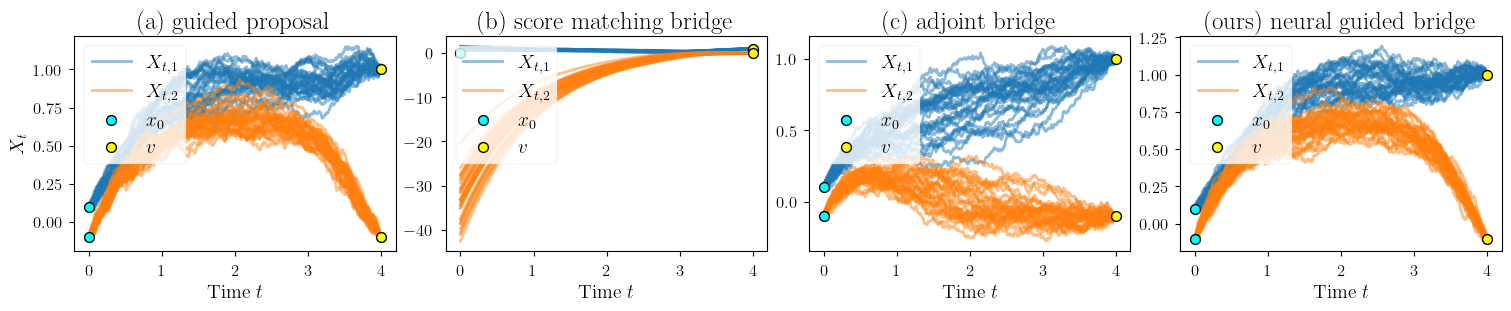

In [48]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), layout="constrained", sharex=True)

make_subplot(axes[0], X_pcn_path, "(a) guided proposal")
make_subplot(axes[1], X_score_path, "(b) score matching bridge")
make_subplot(axes[2], X_adjoint_path, "(c) adjoint bridge")
make_subplot(axes[3], X_neu_path, "(ours) neural guided bridge")

axes[0].set_ylabel(r"$X_t$", fontsize=14)
axes[0].set_xlabel(r"Time $t$", fontsize=14)
axes[1].set_xlabel(r"Time $t$", fontsize=14)
axes[2].set_xlabel(r"Time $t$", fontsize=14)
axes[3].set_xlabel(r"Time $t$", fontsize=14)

fig.savefig("../assets/figures/cell_model/rare_events_results.pdf", dpi=300, bbox_inches="tight")

### Multi-modality

#### Neural bridge

In [88]:
config = read_config("../configs/cell_mm.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

tGrid = TimeGrid(config.sde.T, config.sde.dt, config.sde.t_scheme)
W = WienerProcess(config.sde.W_dim)

X_unc, _ = SDEFactory(config).get_sde()
neural_bridge_model = neurb.NeuralBridge(config)
_ = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_neu = neural_bridge_model.build_neural_bridge()

X_neu_solver = Euler(X_neu, W, tGrid)
X_neu_path = X_neu_solver.solve(
    x0=u, 
    enforced_endpoint=v, 
    batch_size=30,
    training=False
)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/cell_multimode_tanh_linear_None_norm_0.4_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


{'sde': {'name': 'cell', 'X_dim': 2, 'W_dim': 2, 'T': 5.0, 'dt': 0.01, 't_scheme': 'linear', 'params_X_unc': {'alpha': 0.0625, 'sigma': 0.1}, 'params_X_aux': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [-1.0, -1.0], 'v': [-1.0, -1.0], 'eps': 1e-10}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 2, 'hidden_dims': [32, 32, 32, 32], 'activation': 'tanh', 'normalization_type': None, 'dropout_rate': 0.4}, 'training': {'save_name': 'cell_multimode_tanh_linear_None_norm_0.4_dropout_adam_opt', 'learning_rate': 0.001, 'batch_size': 20, 'n_iters_per_epoch': 500, 'n_epochs': 15, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps_ratio': 0.0, 'clip_norm': 1.0}, 'mcmc': {'eta': 0.9, 'n_chains': 1, 'n_iters': 10000, 'n_burn_in': 4000}}


#### score matching

In [50]:
config = read_config("../configs/cell_mm_score.yaml")
print(config)

score_model = score.ScoreMatchingReversedBridge(config)
_ = score_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/score/")
Y_score = score_model.build_reversed_bridge()

Y_score_solver = Euler(Y_score, W, tGrid)
Y_score_path = Y_score_solver.solve(
    x0=v,
    enforced_endpoint=None,
    batch_size=30,
    training=False
)
X_score_path = SamplePath(
    xs=Y_score_path.xs[:, ::-1, :],
    ts=Y_score_path.ts
)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/score/cell_multimode_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


{'sde': {'name': 'cell', 'X_dim': 2, 'W_dim': 2, 'T': 5.0, 'dt': 0.01, 't_scheme': 'linear', 'params_X_unc': {'alpha': 0.0625, 'sigma': 0.1}, 'params_X_aux': {'alpha': 0.0625, 'sigma': 0.1}, 'u': [-1.0, -1.0], 'v': [-1.0, -1.0]}, 'network': {'mlp_type': 'mlp', 'out_dim': 2, 'hidden_dims': [32, 32, 32, 32], 't_emb_dim': 32, 't_emb_max_period': 100.0, 't_emb_scaling': 100.0, 'normalization_type': None, 'activation': 'tanh', 'dropout_rate': 0.0}, 'training': {'save_name': 'cell_multimode_tanh_linear_None_norm_0.0_dropout_adam_opt', 'learning_rate': 0.0005, 'batch_size': 32, 'n_iters_per_epoch': 1000, 'n_epochs': 20, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps_ratio': 0.1, 'clip_norm': 1.0}}


#### Adjoint forward

In [51]:
config = read_config("../configs/cell_mm_adjoint.yaml")
print(config)

from flax.training import checkpoints
from legacies.adjoint_forward.models.score_mlp import ScoreMLP
from legacies.adjoint_forward.sdes import sde_cell_model, sde_utils
from legacies.adjoint_forward.training import train_utils
network = ScoreMLP(**config.network)
ckpt = checkpoints.restore_checkpoint(
    ckpt_dir=os.path.abspath("../assets/ckpts/adjoint/cell_model_mm_0.1sigma"),
    target=None,
    step=0,
    prefix="checkpoint_"
)
params = ckpt["params"]
batch_stats = ckpt["batch_stats"]
trained_score = train_utils.trained_score(network, params, batch_stats)

cell_sde = sde_cell_model.cell_model(
    T=config.sde.T, 
    N=int(config.sde.T / config.sde.dt), 
    alpha=config.sde.alpha, 
    sigma=config.sde.sigma
)
n_samples = 30
rng_keys = jax.random.split(jax.random.PRNGKey(42), n_samples)
xs_star = jax.vmap(
    sde_utils.conditioned,
    in_axes=(0, None, None, None)
)(rng_keys, u, cell_sde, trained_score)
ts = jnp.arange(0, config.sde.T, config.sde.dt)
X_adjoint_path = SamplePath(
    xs=xs_star,
    ts=ts
)

{'sde': {'T': 5.0, 'dt': 0.01, 'N': 400, 'alpha': 0.0625, 'sigma': 0.1, 'u': [-1.0, -1.0], 'v': [-1.0, -1.0]}, 'network': {'output_dim': 2, 'time_embedding_dim': 32, 'init_embedding_dim': 16, 'activation': 'leaky_relu', 'encoder_layer_dims': [16], 'decoder_layer_dims': [128, 128]}, 'training': {'v': None, 'batch_size': 100, 'epochs_per_load': 1, 'lr': 0.01, 'num_reloads': 100, 'load_size': 100000}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


#### Pre-conditioned Crank-Nicolson

In [67]:
config = read_config("../configs/cell_mm.yaml")

pcn_model = pCN.PreconditionedCrankNicolson(
    X=neural_bridge_model.X_gui,
    config=config
)
pcn_logs, _ = pcn_model.run(log_every=200)
X_pcn_path = SamplePath(
    xs = jnp.concatenate([pcn_logs[i].path.xs for i in range(len(pcn_logs))]),
    ts = pcn_logs[0].path.ts
)

Running pCN with log every 200: 100%|██████████| 10000/10000 [00:06<00:00, 1576.67it/s]
INFO:root:Batch average acceptance rate: 24.93%


#### Brutal force sampling to obtain the "ground truth"

In [53]:
X_unc_solver = Euler(X_unc, W, tGrid)
X_unc_path = X_unc_solver.solve(
    x0=u, 
    batch_size=100_000)
# Create masks for each component's end point conditions
x1_mask = (X_unc_path.xs[:, -1, 0] >= v[0] - 1e-2) & (X_unc_path.xs[:, -1, 0] <= v[0] + 1e-2)
x2_mask = (X_unc_path.xs[:, -1, 1] >= v[1] - 1e-2) & (X_unc_path.xs[:, -1, 1] <= v[1] + 1e-2)
final_mask = x1_mask & x2_mask
X_cond_path = X_unc_path[final_mask]
print(f"Found {X_cond_path.n_samples} samples that satisfy the endpoint conditions out of {X_unc_path.n_samples} samples")

Found 0 samples that satisfy the endpoint conditions out of 100000 samples


Plotting

Text(0.5, 0, 'Time $t$')

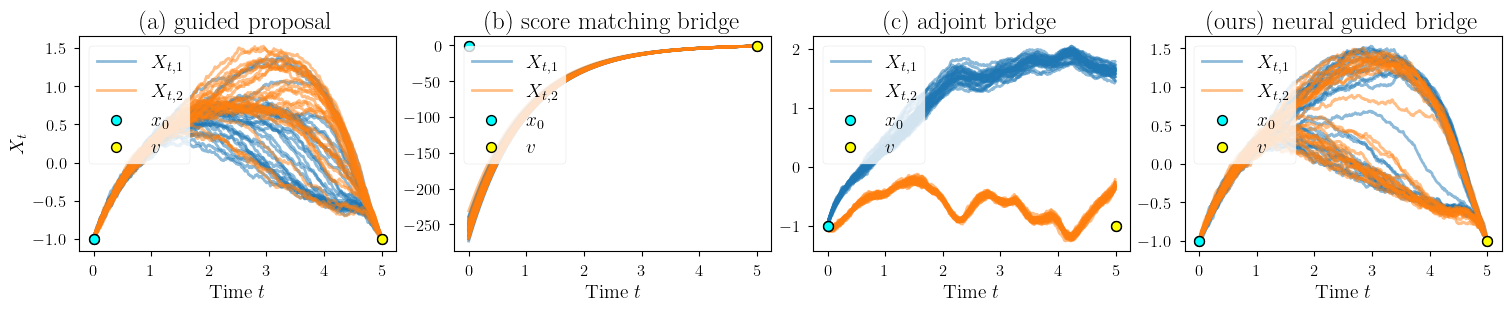

In [89]:
def make_subplot(ax, X_path, title):
    plot_sample_path(
        X_cond_path[:30], 
        ax=ax,
        colors=["grey", "grey"],
        line_plot_kwargs={
            "alpha": 0.5, 
            "linewidth": 2.0, 
            "zorder": 1
        }
    )
    plot_sample_path(
        X_path[:30], 
        ax=ax,
        labels=["$X_{t,1}$", "$X_{t,2}$"],
        line_plot_kwargs={
            "alpha": 0.5, 
            "linewidth": 2.0, 
            "zorder": 2
        }
    )
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.scatter([0.0, 0.0], u, c="cyan", s=50, marker="o", edgecolor="black", linewidth=1.0, label=r"$x_0$", zorder=3)
    ax.scatter([5.0, 5.0], v, c="yellow", s=50, marker="o", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
    ax.legend(fontsize=14, loc="upper left")
    ax.set_title(title, fontsize=18)
    
fig, axes = plt.subplots(1, 4, figsize=(15, 3), layout="constrained")

make_subplot(axes[0], X_pcn_path, "(a) guided proposal")
make_subplot(axes[1], X_score_path, "(b) score matching bridge")
make_subplot(axes[2], X_adjoint_path, "(c) adjoint bridge")
make_subplot(axes[3], X_neu_path, "(ours) neural guided bridge")

axes[0].set_ylabel(r"$X_t$", fontsize=14)
axes[0].set_xlabel(r"Time $t$", fontsize=14)
axes[1].set_xlabel(r"Time $t$", fontsize=14)
axes[2].set_xlabel(r"Time $t$", fontsize=14)
axes[3].set_xlabel(r"Time $t$", fontsize=14)

fig.savefig("../assets/figures/cell_model/multimodality_events_results.pdf", dpi=300, bbox_inches="tight")

### Run pCN on neural bridge

In [90]:
config = read_config("../configs/cell_mm.yaml")

pcn_model = pCN.PreconditionedCrankNicolson(
    X=X_neu,
    config=config
)
pcn_logs, _ = pcn_model.run(log_every=10)
X_pcn_path = SamplePath(
    xs = jnp.concatenate([pcn_logs[i].path.xs for i in range(len(pcn_logs))]),
    ts = pcn_logs[0].path.ts
)

Running pCN with log every 10: 100%|██████████| 10000/10000 [00:10<00:00, 992.94it/s]
INFO:root:Batch average acceptance rate: 54.35%


In [91]:
X_neu_path = X_neu_solver.solve(
    x0=u, 
    enforced_endpoint=v, 
    batch_size=600,
    training=False
)

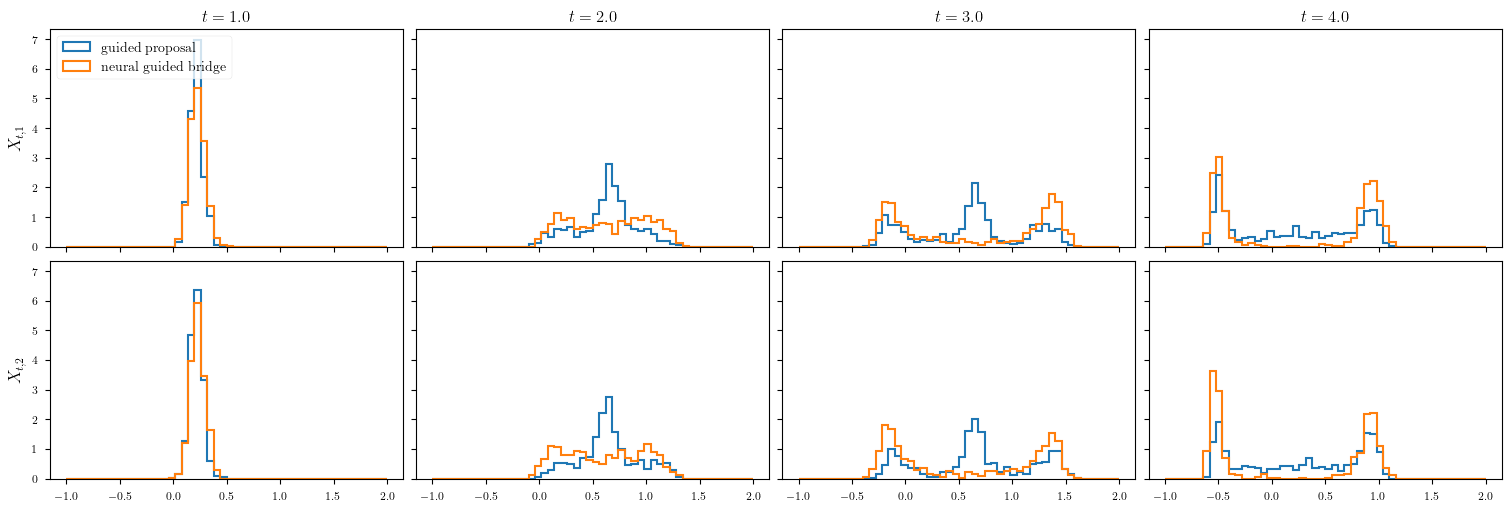

In [94]:
t_slices = [1.0, 2.0, 3.0, 4.0]
x_range = (-1.0, 2.0)
xs = jnp.linspace(x_range[0], x_range[1], 100)

fig, axes = plt.subplots(2, 4, figsize=(15, 5), sharex=True, sharey=True, layout="constrained")

for i, t_slice in enumerate(t_slices):
    t_idx = int(t_slice // config.sde.dt)
    
    # Plot histograms
    axes[0, i].hist(X_pcn_path.xs[:, t_idx, 0], bins=50, density=True, range=x_range,
                    label="guided proposal", histtype='step', edgecolor='C0', linewidth=1.5)
    axes[0, i].hist(X_neu_path.xs[:, t_idx, 0], bins=50, density=True, range=x_range,
                    label="neural guided bridge", histtype='step', edgecolor='C1', linewidth=1.5)
    axes[0, i].set_title(fr"$t = {t_slice:.1f}$", fontsize=12)
    
    axes[1, i].hist(X_pcn_path.xs[:, t_idx, 1], bins=50, density=True, range=x_range,
                    label="guided proposal", histtype='step', edgecolor='C0', linewidth=1.5)
    axes[1, i].hist(X_neu_path.xs[:, t_idx, 1], bins=50, density=True, range=x_range,
                    label="neural guided bridge", histtype='step', edgecolor='C1', linewidth=1.5)
    
axes[0, 0].set_ylabel(r"$X_{t,1}$", fontsize=12)
axes[1, 0].set_ylabel(r"$X_{t,2}$", fontsize=12)
axes[0, 0].legend(loc='upper left', fontsize=10)

#### Multi-modality histogram

In [57]:
X_neu_path = X_neu_solver.solve(
    x0=u, 
    enforced_endpoint=v, 
    batch_size=1000,
    training=False
)

In [60]:
config = read_config("../configs/cell_mm.yaml")

pcn_model = pCN.PreconditionedCrankNicolson(
    X=neural_bridge_model.X_gui,
    config=config
)
pcn_logs, _ = pcn_model.run(log_every=6)
X_pcn_path = SamplePath(
    xs = jnp.concatenate([pcn_logs[i].path.xs for i in range(len(pcn_logs))]),
    ts = pcn_logs[0].path.ts
)

Running pCN with log every 6: 100%|██████████| 10000/10000 [00:06<00:00, 1551.51it/s]
INFO:root:Batch average acceptance rate: 24.93%


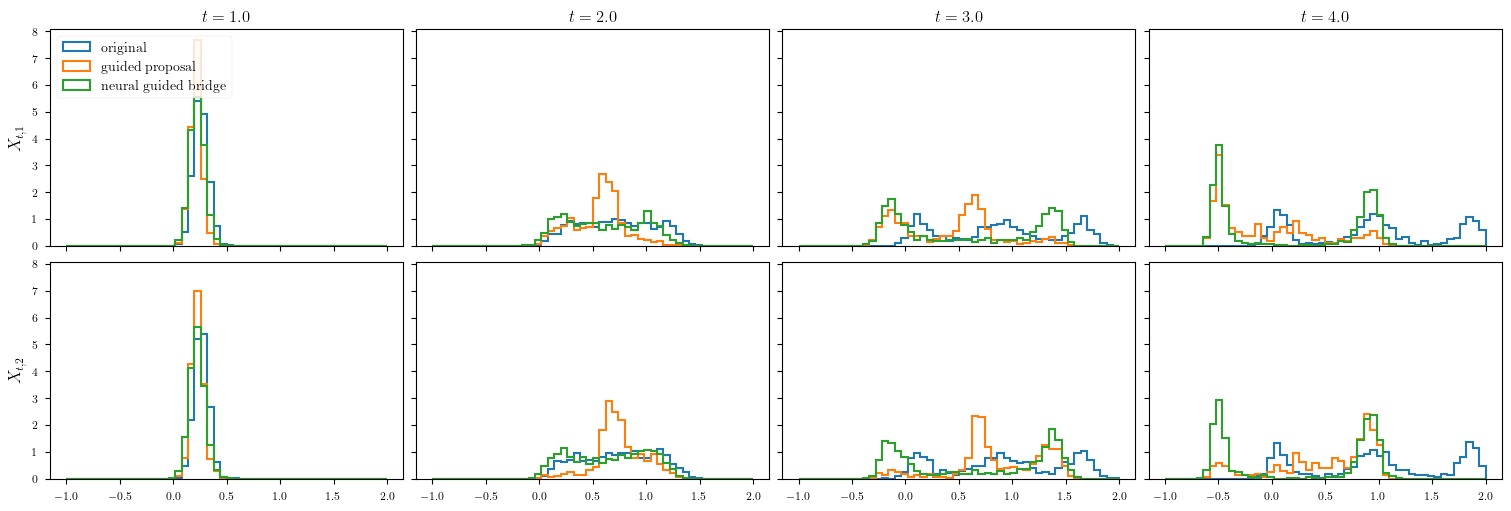

In [63]:
t_slices = [1.0, 2.0, 3.0, 4.0]
x_range = (-1.0, 2.0)
xs = jnp.linspace(x_range[0], x_range[1], 100)

fig, axes = plt.subplots(2, 4, figsize=(15, 5), sharex=True, sharey=True, layout="constrained")

for i, t_slice in enumerate(t_slices):
    t_idx = int(t_slice // config.sde.dt)
    
    # Plot histograms
    axes[0, i].hist(X_unc_path.xs[:1000, t_idx, 0], bins=50, density=True, range=x_range,
                    label="original", histtype='step', edgecolor='C0', linewidth=1.5)
    axes[0, i].hist(X_pcn_path.xs[:, t_idx, 0], bins=50, density=True, range=x_range,
                    label="guided proposal", histtype='step', edgecolor='C1', linewidth=1.5)
    axes[0, i].hist(X_neu_path.xs[:, t_idx, 0], bins=50, density=True, range=x_range,
                    label="neural guided bridge", histtype='step', edgecolor='C2', linewidth=1.5)
    axes[0, i].set_title(fr"$t = {t_slice:.1f}$", fontsize=12)

    
    axes[1, i].hist(X_unc_path.xs[:1000, t_idx, 1], bins=50, density=True, range=x_range,
                    label="original", histtype='step', edgecolor='C0', linewidth=1.5)
    axes[1, i].hist(X_pcn_path.xs[:, t_idx, 1], bins=50, density=True, range=x_range,
                    label="guided proposal", histtype='step', edgecolor='C1', linewidth=1.5)
    axes[1, i].hist(X_neu_path.xs[:, t_idx, 1], bins=50, density=True, range=x_range,
                    label="neural guided bridge", histtype='step', edgecolor='C2', linewidth=1.5)
    
axes[0, 0].set_ylabel(r"$X_{t,1}$", fontsize=12)
axes[1, 0].set_ylabel(r"$X_{t,2}$", fontsize=12)
axes[0, 0].legend(loc='upper left', fontsize=10)

fig.savefig("../assets/figures/cell_model/multimodality_histogram.pdf", dpi=300, bbox_inches="tight")

### Run 2 independent chains

In [84]:
pcn_model = pCN.PreconditionedCrankNicolson(
    X=neural_bridge_model.X_gui,
    config=config
)
pcn_logs_1, _ = pcn_model.run(log_every=10, rng_key=jax.random.PRNGKey(42))
X_pcn_path_1 = SamplePath(
    xs = jnp.concatenate([pcn_logs_1[i].path.xs for i in range(len(pcn_logs_1))]),
    ts = pcn_logs_1[0].path.ts
)


Running pCN with log every 10: 100%|██████████| 10000/10000 [00:06<00:00, 1449.09it/s]
INFO:root:Batch average acceptance rate: 24.93%


In [85]:
pcn_logs_2, _ = pcn_model.run(log_every=10, rng_key=jax.random.PRNGKey(12))
X_pcn_path_2 = SamplePath(
    xs = jnp.concatenate([pcn_logs_2[i].path.xs for i in range(len(pcn_logs_2))]),
    ts = pcn_logs_2[0].path.ts
)

Running pCN with log every 10:   0%|          | 0/10000 [00:00<?, ?it/s]

Running pCN with log every 10: 100%|██████████| 10000/10000 [00:06<00:00, 1457.45it/s]
INFO:root:Batch average acceptance rate: 25.61%


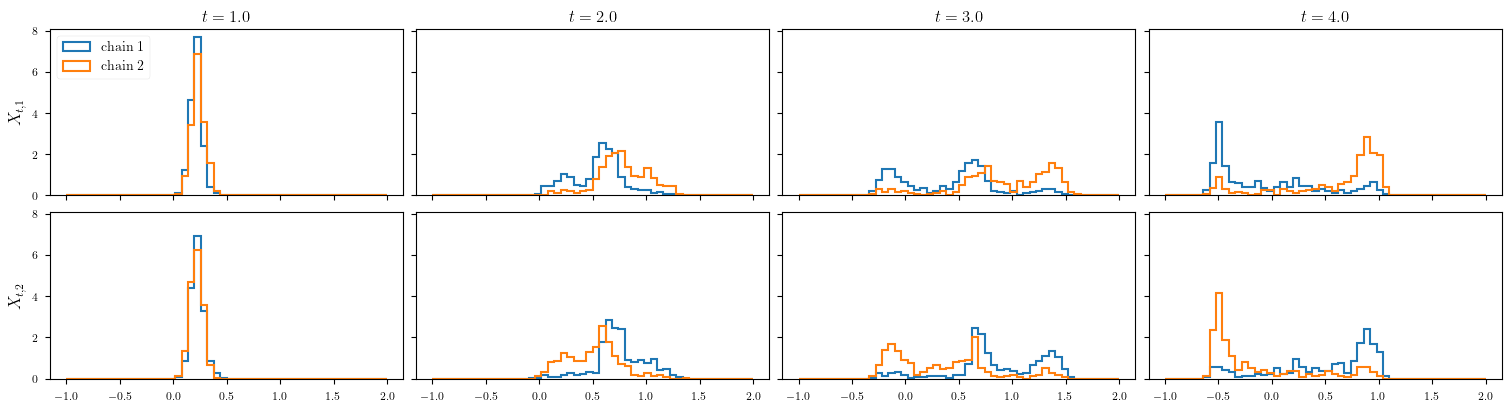

In [87]:
t_slices = [1.0, 2.0, 3.0, 4.0]
x_range = (-1.0, 2.0)
xs = jnp.linspace(x_range[0], x_range[1], 100)

fig, axes = plt.subplots(2, 4, figsize=(15, 4), sharex=True, sharey=True, layout="constrained")

for i, t_slice in enumerate(t_slices):
    t_idx = int(t_slice // config.sde.dt)
    
    # Plot histograms
    axes[0, i].hist(X_pcn_path_1.xs[:, t_idx, 0], bins=50, density=True, range=x_range,
                    label="chain 1", histtype='step', edgecolor='C0', linewidth=1.5)
    axes[0, i].hist(X_pcn_path_2.xs[:, t_idx, 0], bins=50, density=True, range=x_range,
                    label="chain 2", histtype='step', edgecolor='C1', linewidth=1.5)
    axes[0, i].set_title(fr"$t = {t_slice:.1f}$", fontsize=12)
    
    axes[1, i].hist(X_pcn_path_1.xs[:, t_idx, 1], bins=50, density=True, range=x_range,
                    label="chain 1", histtype='step', edgecolor='C0', linewidth=1.5)
    axes[1, i].hist(X_pcn_path_2.xs[:, t_idx, 1], bins=50, density=True, range=x_range,
                    label="chain 2", histtype='step', edgecolor='C1', linewidth=1.5)
    
axes[0, 0].set_ylabel(r"$X_{t,1}$", fontsize=12)
axes[1, 0].set_ylabel(r"$X_{t,2}$", fontsize=12)
axes[0, 0].legend(loc='upper left', fontsize=10)

fig.savefig("../assets/figures/cell_model/multimodality_mcmc_multiple_chains_histograms.pdf", dpi=300, bbox_inches="tight")
plt.show()